<a href="https://colab.research.google.com/github/lcai000/pytorch_fundamentals/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow
1. data (prepare and load)
2. build model
3. fitting the model to data (training)
4. making predictions and evaluating a model (inference)
5. saving and loading a model
6. putting it all together  
https://docs.pytorch.org/tutorials/index.html

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

## 1. Data (preparing and loading)

Data examples in ML:
* Excel spreadsheet
* Images
* Videos
* Audio
* Text
* DNA

Machine learning has two main parts:
* Get data
* Train model on data to find patterns in numerical representations of data

In [2]:
# Create data by using a linear regression

Linear regression

A linear regression has the formula `y=β0​+β1​x+ϵ`
* y is what we try to predict(label)
* x is the *features* we use to explain the varaition in y
* β0​ is the "y intercept" or the predicted y value when x is 0
* β1 is the slope - the change in y per unit of x
* ϵ (epsilon) is the error term which accounts for variation the function cannot explain

The formula can be simplified to `y=aX+b`

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets (one of the most important concepts in machine learning)

In [4]:
# Create a train/test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split],y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualize the data better by graphing

In [55]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None,):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data") # plot training data in blue
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data") # plot testing data in green

  if predictions is not None:
    plt.scatter(test_data,predictions,c="r", s=5, label="Predictions")

  plt.legend(prop={"size":14})

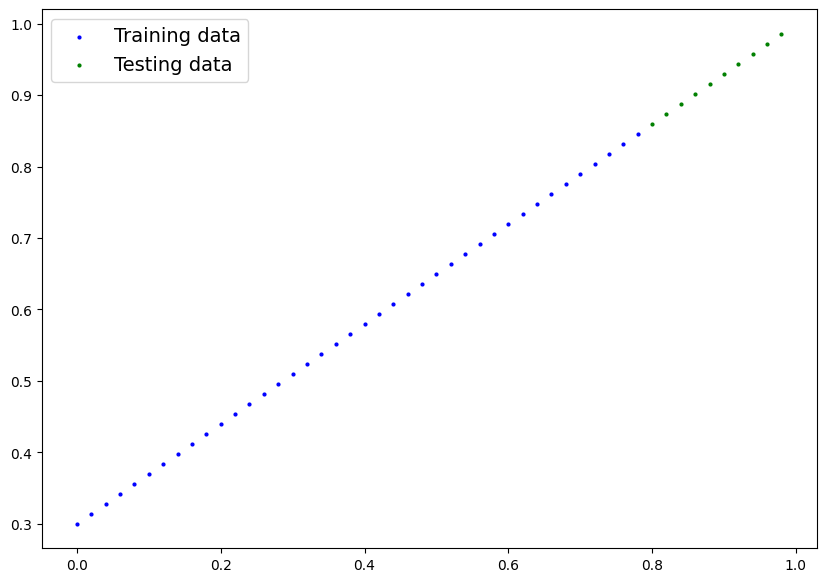

In [6]:
plot_predictions()

## 2. Build model
what the linear regression model does:
* start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

It uses two main algorithms:
1. Gradient descent
2. Backpropagation

Gradient descent:


In [38]:
from torch import nn

# Linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.weights * x + self.bias # linear regression formula


### PyTorch model essentials
* torch.nn - contains all buildings for neural networks
* torch.nn.Parameter - the parameters the model tries to learn
* torch.nn.Module - The base class for all neural network modules, if subclasseed, forword() method should be overwritten
* torch.optim - PyTorch optimizers.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happns in the forward computation

### Checking the contents of the PyTorch model
Check model parameters using `.parameters()`


In [41]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a sublcass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [33]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Making prediction using `torch.inference_model()`

To check the model's predictive power, we can see how well it predicts `y_test` based on `x_test`.
When we pass data trhough the model, it's going to run it through the `forward()` method.

In [34]:
# inputs and ideal outputs
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [52]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [59]:
# alternative way to make prediction
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

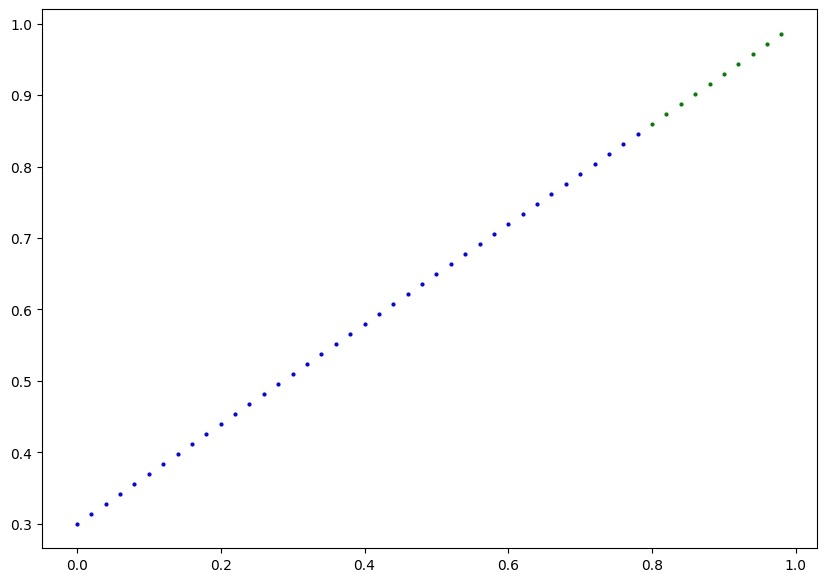

In [58]:
plot_predictions(predictions=y_preds)